In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_parquet('data/train-00000-of-00138-de54d6200ce4d5fa.parquet')

In [9]:
print("Shape of dataset: ", df.shape)
print("Columns: ", df.columns)

Shape of dataset:  (1148, 4)
Columns:  Index(['image', 'spectrum', 'redshift', 'targetid'], dtype='object')


In [18]:
idx = 0
image = df['image'][idx]
spectrum = df['spectrum'][idx]
redshift = df['redshift'][idx]
targetid = df['targetid'][idx]

start = 3600
end = 9824
step = 0.8

number_list = [x for x in range(int(start * 10), int(end * 10), int(step * 10))]
wavelength_domain = [x / 10 for x in number_list]  # Converting back to original scale

print(len(wavelength_domain))

7780


In [46]:
def plot_galaxy(idx):
    image = df['image'][idx]
    spectrum = df['spectrum'][idx]
    redshift = df['redshift'][idx]
    targetid = df['targetid'][idx]
    image_array = np.array(image)

    # Now, extract RGB values into a flat structure first
    # Here we create a list of lists to gather RGB values
    rgb_values = []
    
    for row in image_array:
        # Each row is expected to be an array of shape (152,)
        rgb_row = [pixel for pixel in row]  # Each pixel is an array of shape (3,)
        rgb_values.append(rgb_row)
    
    # Convert to a numpy array
    rgb_values = np.array(rgb_values) #Adding a super random multiplier just to try to visualize this better.
    normalized_image = np.clip(rgb_values, 0, None)  # Remove negatives
    normalized_image = normalized_image / np.max(normalized_image)  # Scale to [0, 1]
    
    # Convert to uint8 for proper visualization
    visual_image = (normalized_image * 255).astype(np.uint8)
    
    # Plot the image
    plt.title(f'Galaxy ID: {targetid}')  # Use targetid for identification
    plt.imshow(visual_image)
    plt.axis('off')  # Turn off axis
    plt.show()

In [45]:
def plot_spectrum(df, idx):
    plt.figure(figsize=(12, 3))  # Adjust figsize as needed
    # Plot the spectrum
    plt.plot(wavelength_domain,spectrum[:-1])
    
    # Set title or labels if needed
    plt.title(f'Spectrum ID: {df["targetid"][idx]}')  # Use targetid for identification
    plt.xlabel('Wavelength')  # Replace with actual x-axis label if available
    plt.ylabel('Intensity')    # Replace with actual y-axis label if available
    
    plt.show()  # Show each spectrum one after another


# Examples

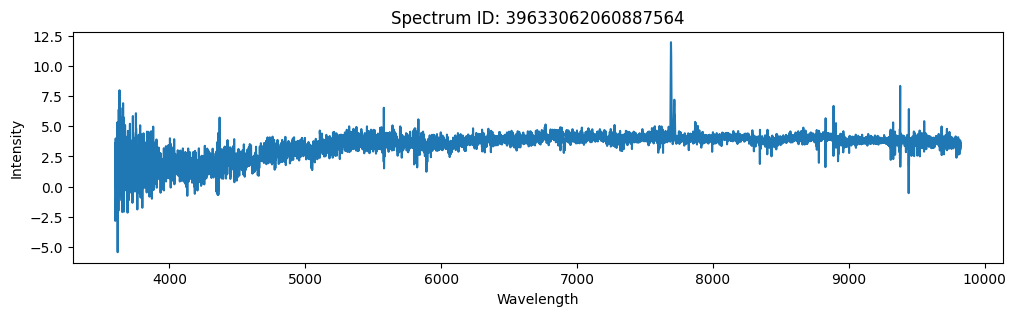

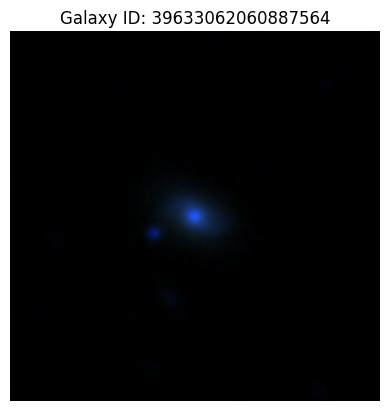

In [41]:
plot_spectrum(df,0)
plot_galaxy(0)

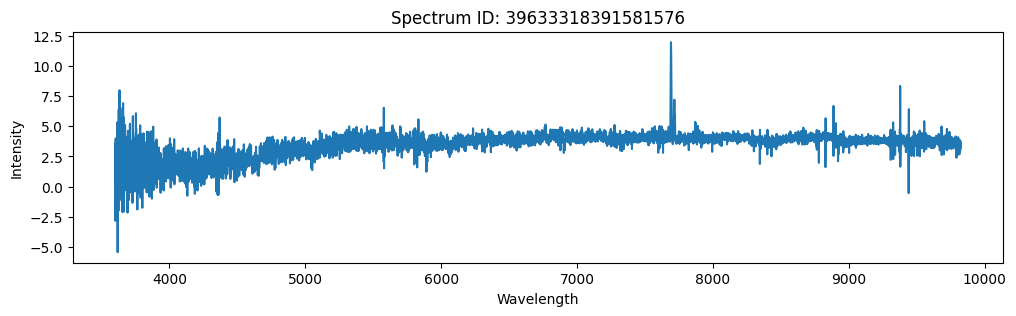

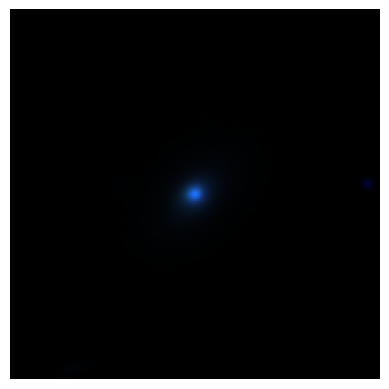

In [33]:
plot_spectrum(df,100)
plot_galaxy(100)

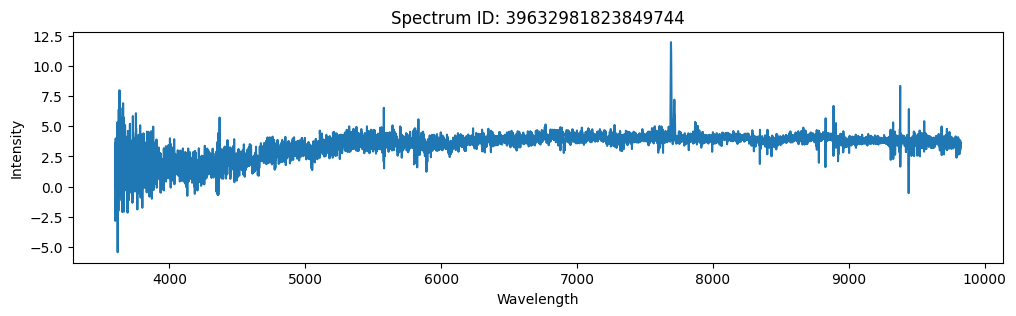

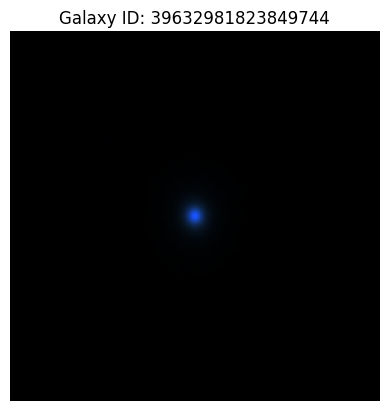

In [42]:
plot_spectrum(df,500)
plot_galaxy(500)

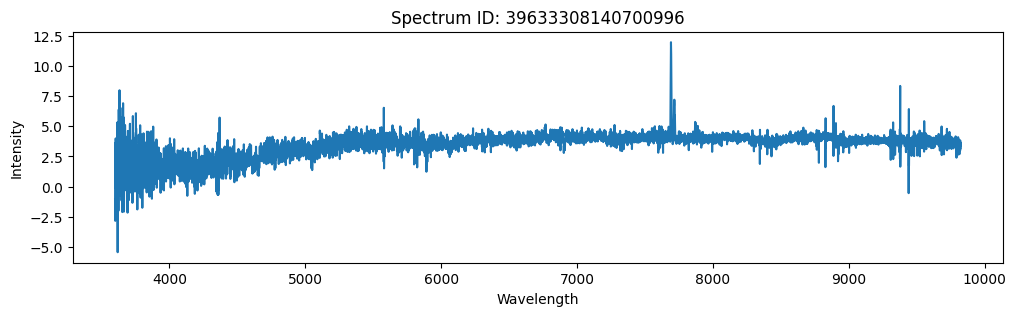

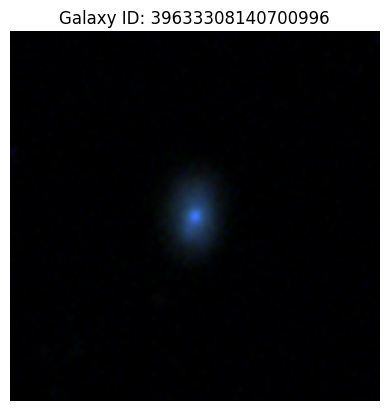

In [50]:
plot_spectrum(df,1147)
plot_galaxy(1147)

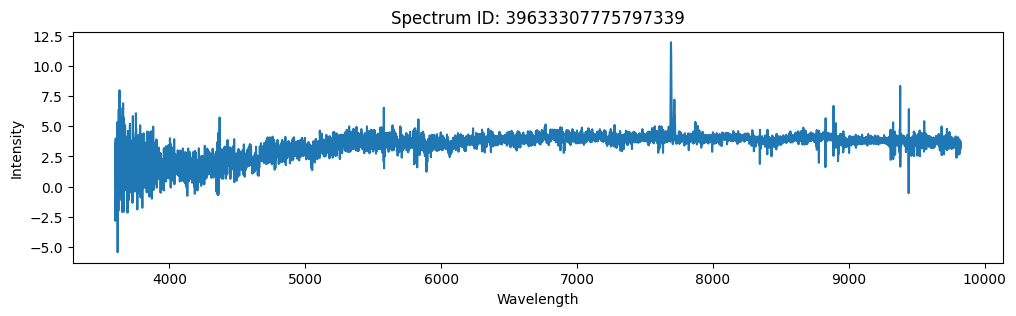

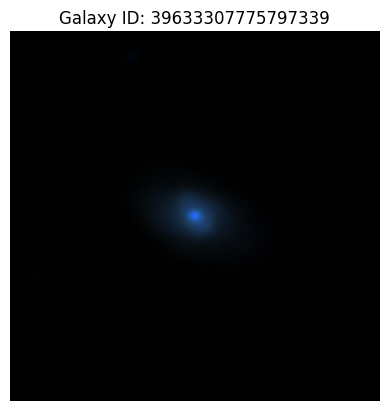

In [51]:
plot_spectrum(df,1100)
plot_galaxy(1100)

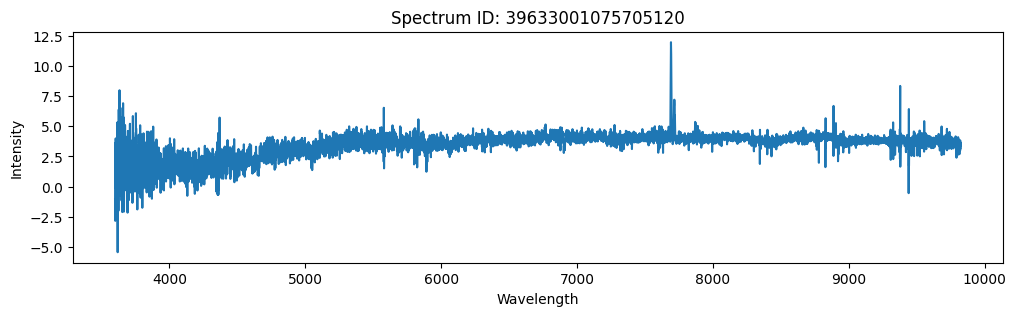

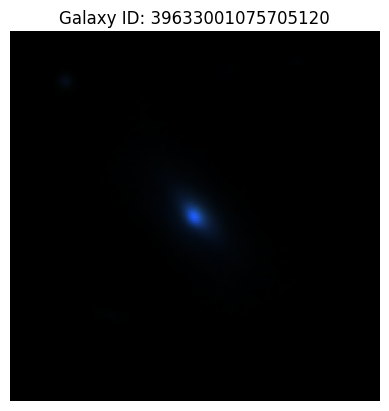

In [52]:
plot_spectrum(df,200)
plot_galaxy(200)

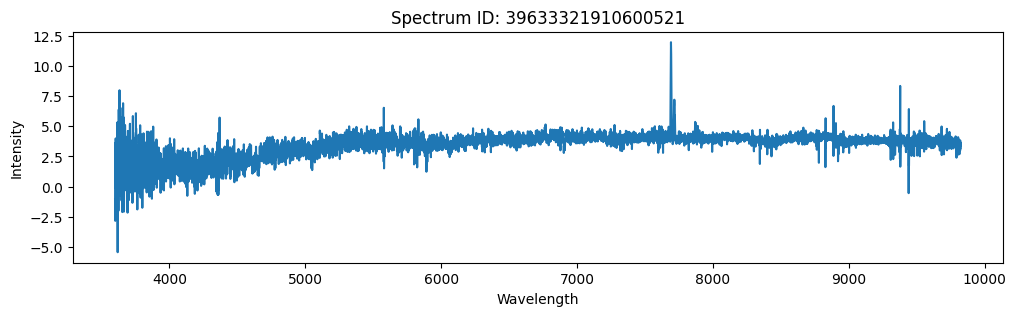

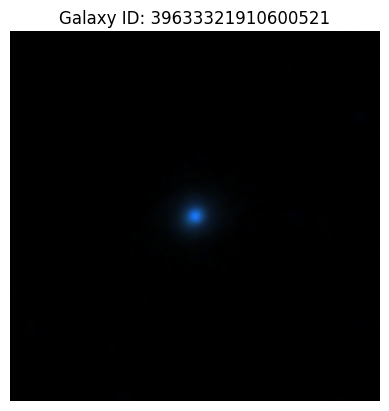

In [53]:
plot_spectrum(df,400)
plot_galaxy(400)

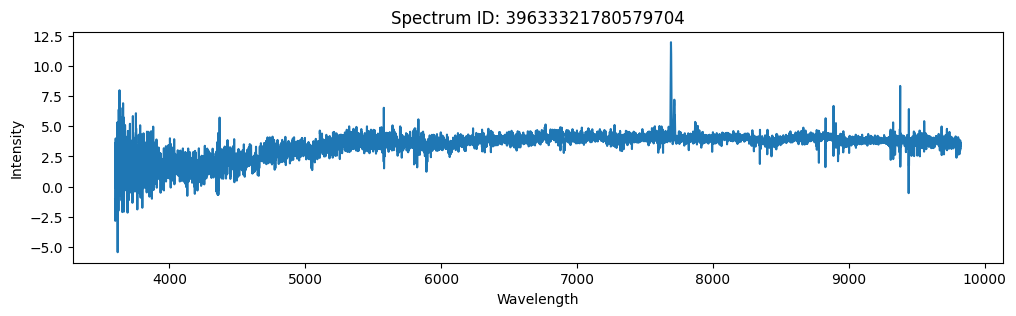

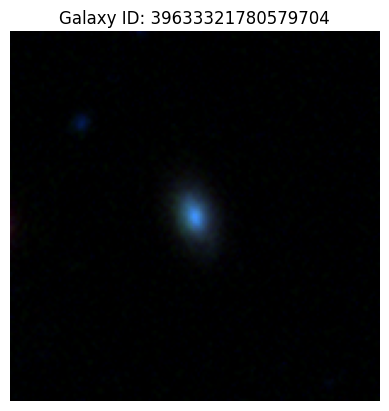

In [54]:
plot_spectrum(df,600)
plot_galaxy(600)

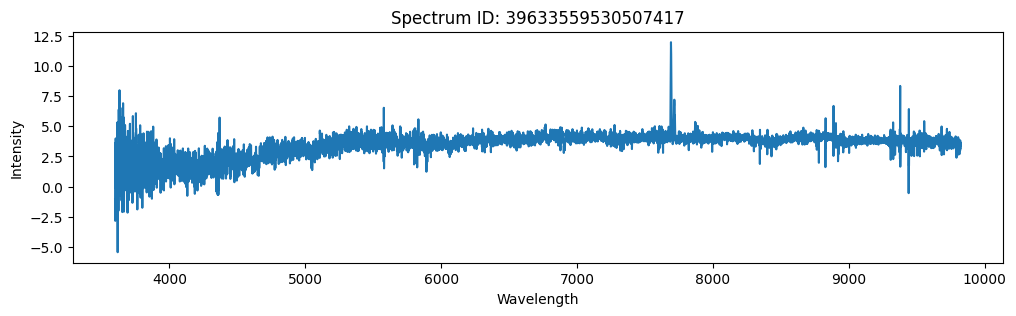

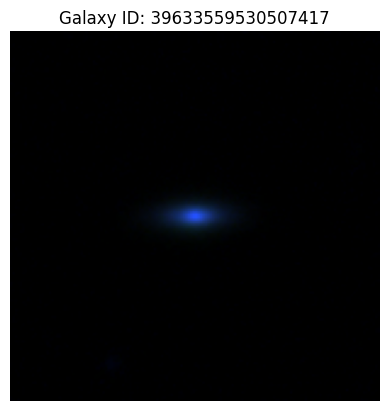

In [55]:
plot_spectrum(df,700)
plot_galaxy(700)